In [2]:
import sys
sys.path.append('../..')
sys.path.append('../data')
sys.path.append('../../helper_code')

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import numpy as np
import numba
import pandas as pd
from IPython.display import display
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim


from helper_code.custom_kernel import create_similarity_matrix_nb, extended_gaussian_kernel_nb

In [4]:
input_dataset = ['c', 'c_lexi', 'CE', 'CE_lexi', 'CSE', 'CSE_lexi']
dataset_dict = {}

for data in input_dataset:
    dataset_dict[data] = np.array(pd.read_csv(f'../data/coronene_training_data/{data}.csv'))
    dataset_dict[f"IDM_{data}"] = np.array(pd.read_csv(f'../data/coronene_training_data/[IDM]{data}.csv'))

D_e_tot = np.array(pd.read_csv(f'../data/coronene_training_data/D_e_tot.csv'))
D_e_elec = np.array(pd.read_csv(f'../data/coronene_training_data/D_e_elec.csv'))
D_e_atom = np.array(pd.read_csv(f'../data/coronene_training_data/D_e_atom.csv'))
DD_etot = np.array(pd.read_csv(f'../data/coronene_training_data/DD_e_tot.csv'))

In [5]:
print(D_e_atom.shape)

(2043, 1)


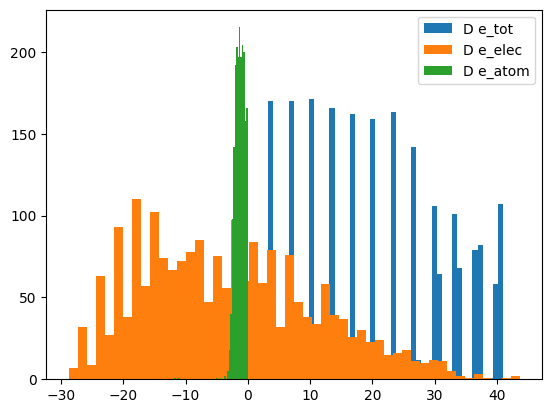

In [6]:
plt.hist(D_e_tot, bins=50, label="D e_tot")
plt.hist(D_e_elec, bins=50, label='D e_elec')
plt.hist(D_e_atom, bins=50, label="D e_atom")
plt.legend()
plt.show()

In [7]:
print(D_e_atom[:10])

[[-1.56713161]
 [-2.38558163]
 [-1.8164962 ]
 [-2.10551207]
 [-1.9065887 ]
 [-0.73771529]
 [-1.02727315]
 [-1.92192718]
 [-1.63167152]
 [-1.35972558]]


In [9]:
print(dataset_dict.keys())

dict_keys(['c', 'IDM_c', 'c_lexi', 'IDM_c_lexi', 'CE', 'IDM_CE', 'CE_lexi', 'IDM_CE_lexi', 'CSE', 'IDM_CSE', 'CSE_lexi', 'IDM_CSE_lexi'])


In [13]:
print(type(dataset_dict['CSE_lexi']))
print(dataset_dict['CSE_lexi'].shape)

<class 'numpy.ndarray'>
(2043, 24)


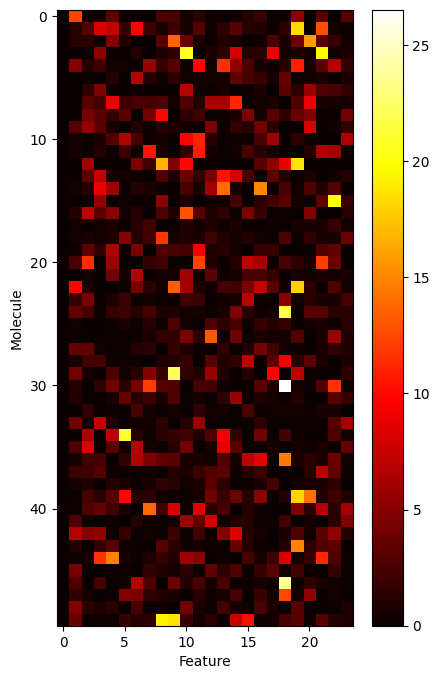

In [21]:
plt.figure(figsize=(5, 8))

# Create the heatmap
plt.imshow(dataset_dict['CSE_lexi'][:50], cmap='hot', interpolation='nearest')

# Add a color bar which maps values to colors
plt.colorbar()

# Adding labels for clarity (optional)
plt.xlabel('Feature')
plt.ylabel('Molecule')

# Show the plot
plt.show()

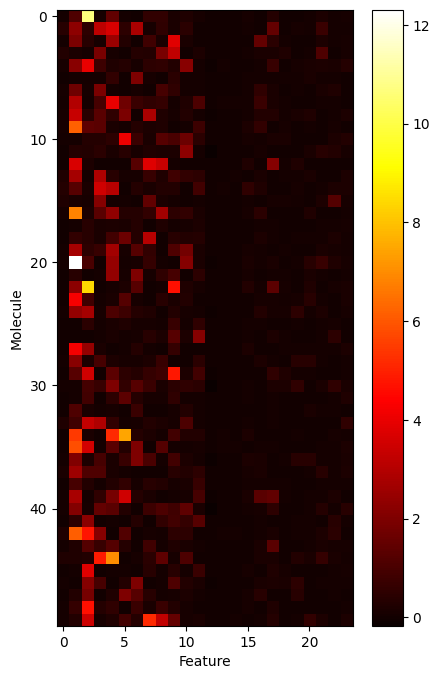

In [23]:
plt.figure(figsize=(5, 8))

# Create the heatmap
plt.imshow(-dataset_dict['IDM_CSE_lexi'][:50], cmap='hot', interpolation='nearest')

# Add a color bar which maps values to colors
plt.colorbar()

# Adding labels for clarity (optional)
plt.xlabel('Feature')
plt.ylabel('Molecule')

# Show the plot
plt.show()

In [38]:
X_train = dataset_dict['CSE_lexi']
y_train = D_e_elec

params = {'alpha': 2.2425013674157485e-08, 'gamma': 8.136151536502313e-08, 'kernel': 'rbf'}
model = KernelRidge(**params)

neg_mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=2)
mae_scores = -neg_mae_scores
avg_mae = mae_scores.mean()

for fold, mae in enumerate(mae_scores):
    print(f"Fold {fold+1}: MAE = {mae}")
print(f"Average MAE across all folds: {avg_mae}")

Fold 1: MAE = 6.759063913217292
Fold 2: MAE = 6.5070278626901255
Average MAE across all folds: 6.633045887953709


In [36]:
X_train = dataset_dict['CSE_lexi']
y_train = np.random.rand(D_e_tot.shape[0], D_e_tot.shape[1])

params = {'alpha': 2.2425013674157485e-08, 'gamma': 8.136151536502313e-08, 'kernel': 'rbf'}
model = KernelRidge(**params)

neg_mae_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=2)
mae_scores = -neg_mae_scores
avg_mae = mae_scores.mean()

for fold, mae in enumerate(mae_scores):
    print(f"Fold {fold+1}: MAE = {mae}")
print(f"Average MAE across all folds: {avg_mae}")

Fold 1: MAE = 0.2518399632913796
Fold 2: MAE = 0.2587589666590603
Average MAE across all folds: 0.25529946497521994


In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(24, 10)  
        self.linear2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

model = NeuralNetwork()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

X_train = torch.tensor(dataset_dict['CSE_lexi'][:1000]).float()
y_train = torch.tensor(D_e_elec[:1000]).float()

# Training loop
for epoch in range(1000):  # Number of epochs
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Print statistics
    if epoch%100 == 0:
        print(f'Epoch [{epoch}/10], Loss: {loss.item():.4f}')

# Predicting output (just an example, replace X_test with your test data)
X_test = torch.from_numpy(dataset_dict['CSE_lexi'][1000:]).float()
predictions = model(X_test)
Y_test = torch.from_numpy(D_e_elec[1000:]).float()

print(type(predictions))
print(predictions.shape)


Epoch [0/10], Loss: 11.9516
Epoch [100/10], Loss: 6.8517
Epoch [200/10], Loss: 5.5462
Epoch [300/10], Loss: 5.3783
Epoch [400/10], Loss: 5.2857
Epoch [500/10], Loss: 5.1854
Epoch [600/10], Loss: 5.0948
Epoch [700/10], Loss: 5.0872
Epoch [800/10], Loss: 5.0547
Epoch [900/10], Loss: 5.1336
<class 'torch.Tensor'>
torch.Size([1043, 1])
